Code ran under dev branch of  
Pyro (635c9ea895a4f627007155723c9a363ec27dac1f)  
and master branch of  
Pytorch (5b142e5344a4c13315cbf70425767dc43b9cd939)

In [1]:
%pylab inline
from tqdm import tqdm, trange
from collections import defaultdict, namedtuple
import numpy as np
import pymc3 as pm

import torch
import torch.nn as nn
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc.mcmc import MCMC

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


AttributeError: module 'torch.distributions' has no attribute 'LogNormal'

In [ ]:
pyro.__version__

# High-D Gaussian

In [3]:
ndim, num_obs = 10, 100
nchain = 2
mu0 = np.arange(ndim)
data = np.random.randn(num_obs, ndim) + mu0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
100%|██████████| 1000/1000 [00:04<00:00, 224.88it/s]
Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu]
100%|██████████| 2000/2000 [00:03<00:00, 610.57it/s]
The number of effective samples is smaller than 25% for some parameters.


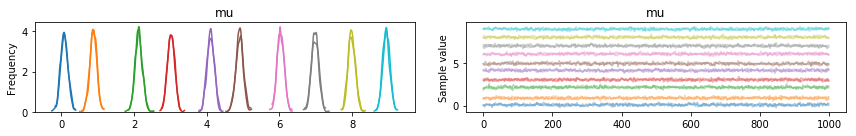

In [4]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10., shape=ndim)
    obs = pm.Normal('obs', mu, 1., observed=data)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

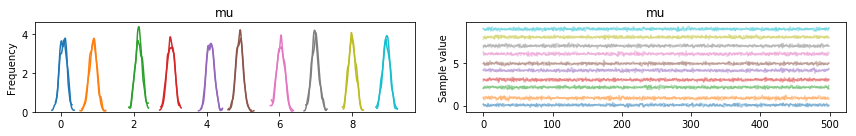

In [5]:
pm.traceplot(trace);

## In Pyro (HMC)

In [6]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                         mu=Variable(torch.Tensor(torch.zeros(ndim))), 
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.Tensor(torch.ones(ndim))), 
                obs=data_)

In [7]:
draw = 2000
ntune = 1000
n_steps = max(1, int(step.path_length / step.step_size))
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)
mcmc_run = MCMC(hmc_kernel, num_samples=draw, warmup_steps=ntune)

mtrace = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace.append(np.asarray(post_pyro)[ntune+1:])

100%|██████████| 2001/2001 [00:51<00:00, 38.93it/s]


In [8]:
mtrace[0].shape

(1000, 10)

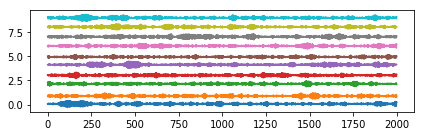

In [9]:
mtrace = np.asarray(mtrace).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace);
plt.tight_layout();

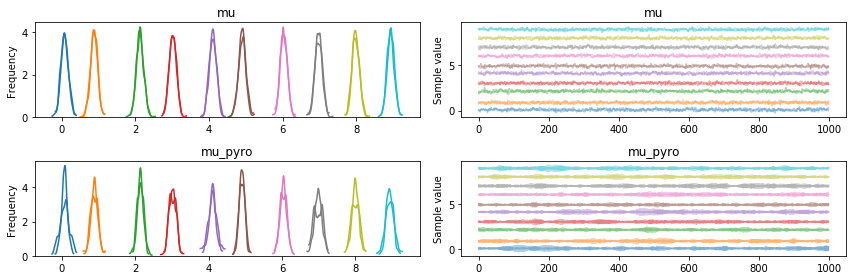

In [10]:
trace_hmc.add_values(dict(mu_pyro=mtrace))
pm.traceplot(trace_hmc);

## In Pyro (NUTS)

In [11]:
from pyro.infer.mcmc.nuts import NUTS

ImportError: No module named 'pyro.infer.mcmc.nuts'

In [ ]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                         mu=Variable(torch.Tensor(torch.zeros(ndim))), 
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.Tensor(torch.ones(ndim))), 
                obs=data_)

In [ ]:
draw = 2000
ntune = 1000
hmc_kernel = NUTS(m2, step_size=step.step_size)
mcmc_run = MCMC(hmc_kernel, num_samples=draw, warmup_steps=ntune)

mtrace = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace.append(np.asarray(post_pyro)[ntune+1:])

In [ ]:
mtrace[0].shape

In [ ]:
mtrace = np.asarray(mtrace).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace);
plt.tight_layout();

In [ ]:
trace_hmc.add_values(dict(mu_pyro=mtrace))
pm.traceplot(trace_hmc);

## Getting logp from pyro

In [11]:
def m2():
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                         mu=Variable(torch.Tensor(torch.zeros(ndim))), 
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.Tensor(torch.ones(ndim))), 
                obs=data_)
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)

In [12]:
hmc_kernel.setup()

In [13]:
hmc_kernel.initial_trace()

In [14]:
trace = hmc_kernel._prototype_trace

In [15]:
z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
z

{'mu': Variable containing:
 -10.2269
  12.2213
  16.2495
   8.5181
  -4.7493
  -9.7469
  11.9344
  -7.0148
   3.2809
   5.9521
 [torch.FloatTensor of size (10,)]}

In [16]:
trace.log_pdf()

Variable containing:
-52396.2383
[torch.FloatTensor of size (1,)]

In [17]:
z['mu'].numpy()

array([-10.226871 ,  12.221329 ,  16.24955  ,   8.518072 ,  -4.749312 ,
        -9.746944 ,  11.934371 ,  -7.014823 ,   3.280884 ,   5.9521236],
      dtype=float32)

In [18]:
from scipy import stats as st
st.norm.logpdf(data, loc=z['mu'].numpy(), scale=1.).sum()

-52359.291560985854

In [19]:
st.norm.logpdf(data, loc=mu0, scale=1.).sum()

-1400.5936553345123

In [20]:
print(hmc_kernel._args, hmc_kernel._kwargs,'/t')

() {} /t


In [21]:
trace.nodes

NodeView(('_RETURN', 'obs', '_INPUT', 'mu'))

In [22]:
trace.nodes['mu']['value']

Variable containing:
-10.2269
 12.2213
 16.2495
  8.5181
 -4.7493
 -9.7469
 11.9344
 -7.0148
  3.2809
  5.9521
[torch.FloatTensor of size (10,)]

In [23]:
hmc_kernel._get_trace(z).log_pdf()

Variable containing:
-52396.2383
[torch.FloatTensor of size (1,)]

In [24]:
z_next = {key: Variable(torch.Tensor(mu0)) for key, val in z.items()}
z_next

{'mu': Variable containing:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 [torch.FloatTensor of size (10,)]}

In [25]:
hmc_kernel._get_trace(z_next).log_pdf()

Variable containing:
-1434.2339
[torch.FloatTensor of size (1,)]

# Chain of Gaussian
adapted from the test case
https://github.com/uber/pyro/blob/7b3a0a833b836c1b7b1e981091b514baec819c40/tests/infer/mcmc/test_hmc.py#L32-L37

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:02<00:00, 872.23it/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


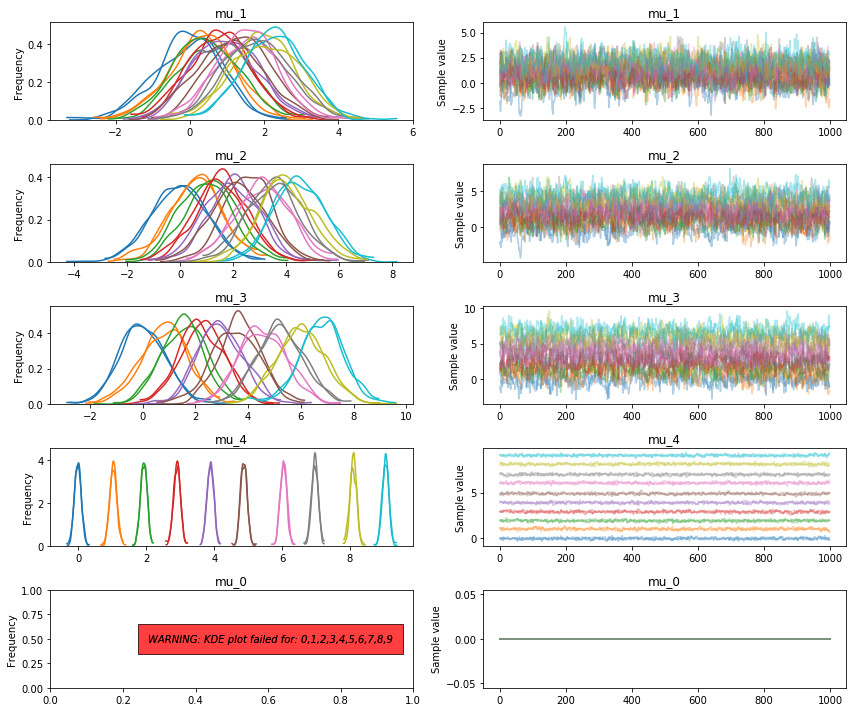

In [26]:
import theano.tensor as tt
import theano

nlayer = 4
with pm.Model() as chain_gaussian:
    mu = pm.Deterministic('mu_0', tt.zeros(ndim))
    for i in range(nlayer):
        mu = pm.Normal('mu_{}'.format(i+1), mu=mu, sd=1., shape=ndim)
    obs = pm.Normal('obs', mu=mu, sd=1., observed=data)
    
    step = pm.HamiltonianMC(step_scale=.01)
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

In [27]:
import logging
from pyro.distributions.util import torch_ones_like, torch_zeros_like

logging.basicConfig(format='%(levelname)s %(message)s')
logger = logging.getLogger('pyro')
logger.setLevel(logging.INFO)

class GaussianChain(object):

    def __init__(self, dim, chain_len):
        self.dim = dim
        self.chain_len = chain_len
        self.mu_0 = Variable(torch_zeros_like(torch.Tensor(self.dim)), requires_grad=True)
        self.lambda_prec = Variable(torch_ones_like(torch.Tensor(self.dim)))

    def model(self, data):
        mu = pyro.param('mu_0', self.mu_0)
        lambda_prec = self.lambda_prec
        for i in range(1, self.chain_len + 1):
            mu = pyro.sample('mu_{}'.format(i), dist.normal, mu=mu, sigma=Variable(lambda_prec.data))
        pyro.sample('obs', dist.normal, mu=mu, sigma=Variable(lambda_prec.data), obs=data)


fixture = GaussianChain(dim=ndim, chain_len=nlayer)
num_samples=1000
warmup_steps=300
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(fixture.model, **hmc_params)
mcmc_run = MCMC(hmc_kernel, num_samples, warmup_steps)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

data_ = Variable(torch.Tensor(data))
for t, _ in mcmc_run._traces(data_):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 65.
INFO Acceptance rate: 0.8769230769230769
INFO Iteration: 130.
INFO Acceptance rate: 0.7384615384615385
INFO Iteration: 195.
INFO Acceptance rate: 0.6615384615384615
INFO Iteration: 260.
INFO Acceptance rate: 0.6615384615384615
INFO Iteration: 325.
INFO Acceptance rate: 0.6369230769230769
INFO Iteration: 390.
INFO Acceptance rate: 0.617948717948718
INFO Iteration: 455.
INFO Acceptance rate: 0.5978021978021978
INFO Iteration: 520.
INFO Acceptance rate: 0.5826923076923077
INFO Iteration: 585.
INFO Acceptance rate: 0.588034188034188
INFO Iteration: 650.
INFO Acceptance rate: 0.5815384615384616
INFO Iteration: 715.
INFO Acceptance rate: 0.5762237762237762
INFO Iteration: 780.
INFO Acceptance rate: 0.5782051282051283
INFO Iteration: 845.
INFO Acceptance rate: 0.570414201183432
INFO Iteration: 910.
INFO Acceptance rate: 0.5725274725274725
INFO Iteration: 975.
INFO Acceptance rate: 0.5651282051282052
INFO Iteration: 1040.
INFO Accep

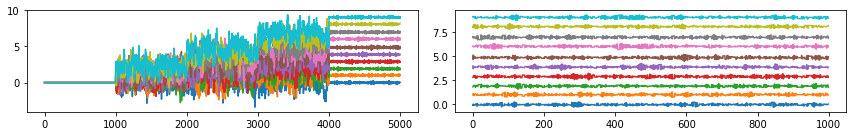

In [28]:
post_pyro = []
for i in range(nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])

post_pyro = np.asarray(post_pyro).reshape([(nlayer+1)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze());
ax[1].plot(post_pyro[4000:, :].squeeze())
plt.tight_layout();

In [29]:
def chain_gaussian2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.param('mu_0', Variable(torch.zeros(ndim), requires_grad=True))
    for i in range(nlayer):
        mu = pyro.sample('mu_{}'.format(i+1), dist.normal,
                         mu=mu, 
                         sigma=Variable(torch.ones(ndim)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.ones(ndim)), 
                obs=data_)
    
draw = 2000
ntune = 1000
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(chain_gaussian2, **hmc_params)
mcmc_run = MCMC(hmc_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 150.
INFO Acceptance rate: 0.76
INFO Iteration: 300.
INFO Acceptance rate: 0.6666666666666666
INFO Iteration: 450.
INFO Acceptance rate: 0.62
INFO Iteration: 600.
INFO Acceptance rate: 0.595
INFO Iteration: 750.
INFO Acceptance rate: 0.5826666666666667
INFO Iteration: 900.
INFO Acceptance rate: 0.5533333333333333
INFO Iteration: 1050.
INFO Acceptance rate: 0.5571428571428572
INFO Iteration: 1200.
INFO Acceptance rate: 0.5425
INFO Iteration: 1350.
INFO Acceptance rate: 0.5385185185185185
INFO Iteration: 1500.
INFO Acceptance rate: 0.53
INFO Iteration: 1650.
INFO Acceptance rate: 0.5242424242424243
INFO Iteration: 1800.
INFO Acceptance rate: 0.5172222222222222
INFO Iteration: 1950.
INFO Acceptance rate: 0.5230769230769231
INFO Iteration: 2100.
INFO Acceptance rate: 0.5261904761904762
INFO Iteration: 2250.
INFO Acceptance rate: 0.5226666666666666
INFO Iteration: 2400.
INFO Acceptance rate: 0.5191666666666667
INFO Iteration: 2550.
I

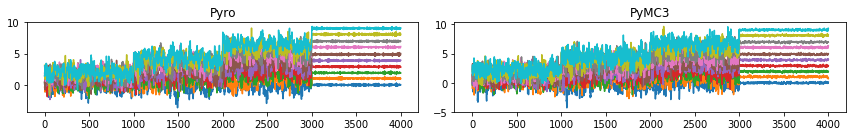

In [30]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])
    
post_pyro = np.asarray(post_pyro).reshape([(nlayer)*1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze());
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze())
ax[1].set_title('PyMC3')

plt.tight_layout();

# Gaussian with sigma

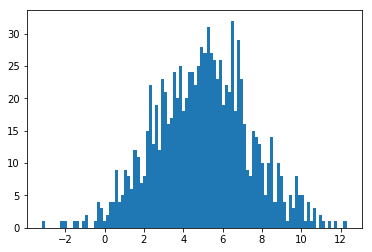

In [31]:
mu0, sigma = 5., 2.4
N = 1000
X = mu0 + np.random.randn(N, 1)*sigma

plt.hist(X, 100);

In [32]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=X)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step)

Auto-assigning NUTS sampler...
INFO Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
INFO NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:01<00:00, 571.17it/s]
The acceptance probability does not match the target. It is 0.881296381533316, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING The acceptance probability does not match the target. It is 0.881296381533316, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [sd_log__, mu]
INFO HamiltonianMC: [sd_log__, mu]
100%|██████████| 2000/2000 [00:02<00:00, 887.42it/s] 
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR The estimated number of effective samp

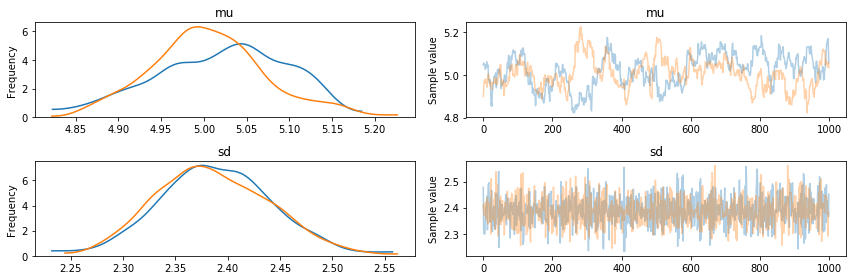

In [33]:
pm.traceplot(trace_hmc);

In [34]:
ndim = 1
def m2():
    data_ = Variable(torch.Tensor(X))
    mu = pyro.sample('mu', dist.normal,
                     mu=Variable(torch.Tensor(torch.zeros(ndim))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim)*100.)))
    sd = pyro.sample('sd', dist.gamma,
                     Variable(torch.Tensor(torch.ones(ndim))),
                     Variable(torch.Tensor(torch.ones(ndim))))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=sd, 
                obs=data_)

In [35]:
n_steps = max(1, int(step.path_length / step.step_size))

hmc_params={'step_size': .025,
            'num_steps': 5}
hmc_kernel = HMC(m2, **hmc_params)

In [36]:
hmc_kernel._reset()

In [37]:
hmc_kernel.setup()

In [38]:
trace = hmc_kernel.initial_trace()

In [39]:
trace.nodes['mu']

{'args': (),
 'baseline': {},
 'cond_indep_stack': [],
 'done': True,
 'fn': <pyro.distributions.random_primitive.RandomPrimitive at 0x119095f48>,
 'is_observed': False,
 'kwargs': {'mu': Variable containing:
   0
  [torch.FloatTensor of size (1,)], 'sigma': Variable containing:
   100
  [torch.FloatTensor of size (1,)]},
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': Variable containing:
  81.8901
 [torch.FloatTensor of size (1,)]}

In [40]:
zorg = dict(mu=mu0, sd=sigma)
z_next = {key: Variable(torch.Tensor(torch.ones(ndim)*zorg[key])) for key in zorg.keys()}
z_next

{'mu': Variable containing:
  5
 [torch.FloatTensor of size (1,)], 'sd': Variable containing:
  2.4000
 [torch.FloatTensor of size (1,)]}

In [41]:
trace = hmc_kernel._get_trace(z_next)

In [42]:
from pyro.ops.integrator import velocity_verlet

z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
r = {name: pyro.sample('r_{}_t={}'.format(name, hmc_kernel._t), hmc_kernel._r_dist[name]) for name in z}
z_new, r_new = velocity_verlet(z, r, hmc_kernel._potential_energy, hmc_kernel.step_size, hmc_kernel.num_steps)

In [43]:
z

{'mu': Variable containing:
  5
 [torch.FloatTensor of size (1,)], 'sd': Variable containing:
  2.4000
 [torch.FloatTensor of size (1,)]}

In [44]:
z_new

{'mu': Variable containing:
  4.9146
 [torch.FloatTensor of size (1,)], 'sd': Variable containing:
  2.4133
 [torch.FloatTensor of size (1,)]}

In [45]:
mcmc_run = MCMC(hmc_kernel, num_samples=1000, warmup_steps=500)
mcmc_run.kernel.setup()
mcmc_run.kernel._prototype_trace.nodes['mu']

{'args': (),
 'baseline': {},
 'cond_indep_stack': [],
 'done': True,
 'fn': <pyro.distributions.random_primitive.RandomPrimitive at 0x119095f48>,
 'is_observed': False,
 'kwargs': {'mu': Variable containing:
   0
  [torch.FloatTensor of size (1,)], 'sigma': Variable containing:
   100
  [torch.FloatTensor of size (1,)]},
 'log_pdf': Variable containing:
 -5.8702
 [torch.FloatTensor of size (1,)],
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': Variable containing:
  83.1943
 [torch.FloatTensor of size (1,)]}

In [46]:
mcmc_run.kernel._prototype_trace.nodes['sd']['value']

Variable containing:
1.00000e-02 *
  7.0620
[torch.FloatTensor of size (1,)]

In [47]:
mcmc_run.kernel._prototype_trace.nodes['mu']['value'] = 5.
mcmc_run.kernel._prototype_trace.nodes['sd']['value'] = 5.

In [48]:
# pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces():
    post_trace['mu'].append(t.nodes['mu']['value'])
    post_trace['sd'].append(t.nodes['sd']['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 75.
INFO Acceptance rate: 0.0
INFO Iteration: 150.
INFO Acceptance rate: 0.0
INFO Iteration: 225.
INFO Acceptance rate: 0.0
INFO Iteration: 300.
INFO Acceptance rate: 0.0
INFO Iteration: 375.
INFO Acceptance rate: 0.0
INFO Iteration: 450.
INFO Acceptance rate: 0.0
INFO Iteration: 525.
INFO Acceptance rate: 0.0
INFO Iteration: 600.
INFO Acceptance rate: 0.0
INFO Iteration: 675.
INFO Acceptance rate: 0.0
INFO Iteration: 750.
INFO Acceptance rate: 0.0
INFO Iteration: 825.
INFO Acceptance rate: 0.0
INFO Iteration: 900.
INFO Acceptance rate: 0.0
INFO Iteration: 975.
INFO Acceptance rate: 0.0
INFO Iteration: 1050.
INFO Acceptance rate: 0.0
INFO Iteration: 1125.
INFO Acceptance rate: 0.0
INFO Iteration: 1200.
INFO Acceptance rate: 0.0
INFO Iteration: 1275.
INFO Acceptance rate: 0.0
INFO Iteration: 1350.
INFO Acceptance rate: 0.0
INFO Iteration: 1425.
INFO Acceptance rate: 0.0
INFO Iteration: 1500.
INFO Acceptance rate: 0.0


# Regression

In [49]:
def m2(X, Y):
    X, Y = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    mu = pyro.sample("mu", dist.normal, Variable(torch.Tensor([0]*N)),
                                        Variable(torch.Tensor([100]*N)))
    b = pyro.sample("b", dist.normal, Variable(torch.Tensor([0]*N)),
                                      Variable(torch.Tensor([10]*N)))
    yhat = mu + X * b
    sd = pyro.sample("sigma", dist.normal, Variable(torch.Tensor([0])), 
                                           Variable(torch.Tensor([2.5])))
    sd_ = sd**2
    return pyro.sample("height", dist.normal, yhat, (sd_).expand_as(mu), obs=Y.squeeze())

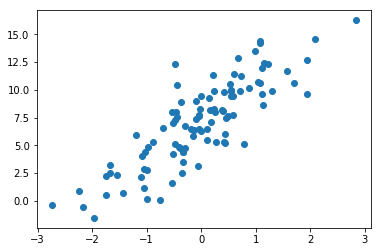

In [50]:
beta = [7., 3.4]
sigma = 2.1
N = 100
X = np.random.randn(N, 1)
Y = beta[0] + beta[1]*X + np.random.randn(N, 1)*sigma

plt.plot(X, Y, 'o');

In [51]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    b = pm.Normal('b', 0., 10.)
    sd = pm.HalfCauchy('sd', 2.5)
    obs = pm.Normal('obs', mu=mu+X*b, sd=sd, observed=Y)
    trace = pm.sample()

Auto-assigning NUTS sampler...
INFO Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, b, mu]
INFO NUTS: [sd_log__, b, mu]
100%|██████████| 1000/1000 [00:01<00:00, 594.34it/s]


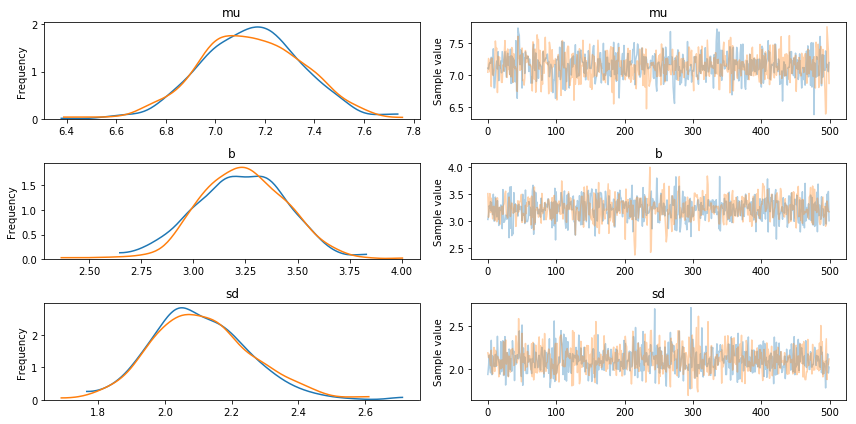

In [52]:
pm.traceplot(trace);

In [53]:
with m:
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [sd_log__, b, mu]
INFO HamiltonianMC: [sd_log__, b, mu]
100%|██████████| 2000/2000 [00:03<00:00, 606.73it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR The estimated number of effective samples is smaller than 200 for some parameters.


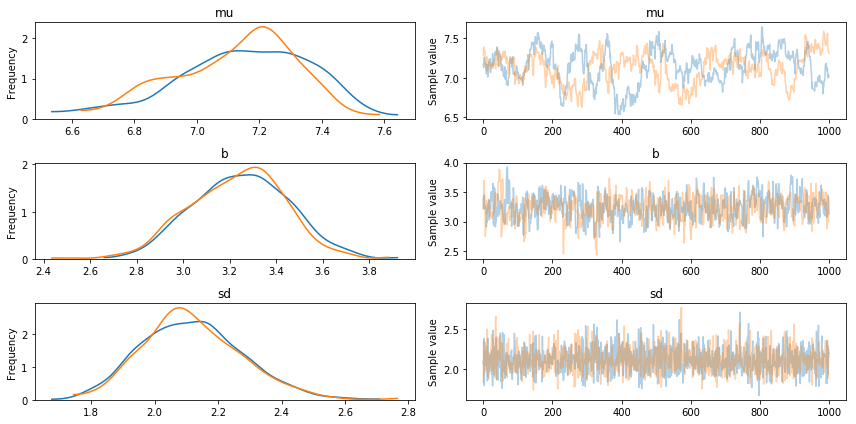

In [54]:
pm.traceplot(trace_hmc);

In [55]:
mu

mu